In [243]:
#http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

#https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

#https://stackoverflow.com/questions/44666787/how-to-make-smoother-wave-by-apply-hamming-window  HAMMING-WINDOW

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, hamming
from scipy.fftpack import fft, realtransforms
from lab1_proto import mspec

In [245]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle=True)['data']


### QUESTION 4.1

In [246]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """

    N = 1 + int((len(samples) - winlen) / winshift)     # first window + how many times the window can be shifted
    frames = np.zeros((N, winlen))

    # init window
    start = 0
    end = start + winlen

    for i in range(N):
        # frame
        frames[i] = samples[start:end]

        # shift window
        start = start + winshift
        end = start + winlen
    return frames
    

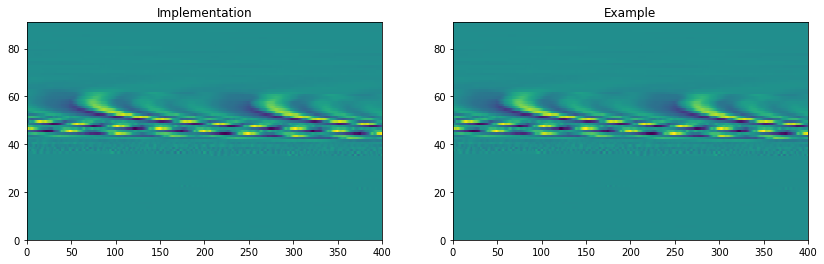

In [247]:
samples = example['samples']
winlen = int(example["samplingrate"]*20/1000)       # number of samples in 20 ms
winshift = int(example["samplingrate"]*10/1000)     # number of samples in 10 ms
frames = enframe(samples, winlen, winshift)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(frames)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['frames'])

### QUESTION 4.2

The function lfilter from scipy.signal takes the following parameters: scipy.signal.lfilter(b, a, x) and dose the following:

a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]

Since we want to compute y[n]=x[n] -αx[n-1], we can set a=1 and b = (1, -p)

In [248]:
def preemp(input_frames, p):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    a = [1]
    b = [1, -p]
    for frame in range(len(input_frames)):
        input_frames[frame]  = lfilter(b,a,input_frames[frame])
    return input_frames
    

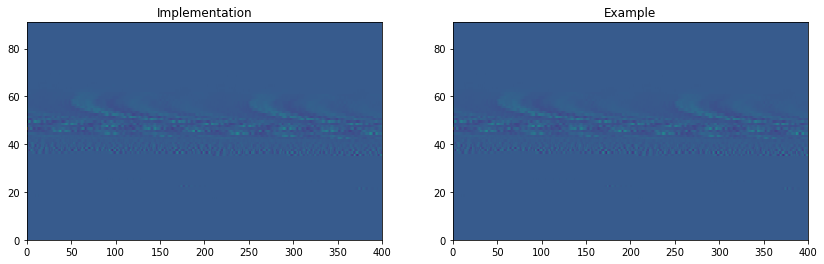

In [249]:
preemp_frames = preemp(frames, p=0.97)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(preemp_frames)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['preemph'])

### QUESTION 4.3

why this windowing should be applied to the frames of speech signal: If we take the Fourier transform of rectangular windows that we otained in the previous steps, we will obtain very high sidelobes. Thus, it is better to apply a Hamming window that do not have a constant value of 1 for each point in the window function. the fourier transform in this case will be smooter, with very little sidelobes. A disadvantage of this function is that the main lobe will be a bit wider. 

In [250]:
def windowing(input_frames):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    hamming_window = hamming(input_frames.shape[1], False)
    windowed = np.multiply(input_frames, hamming_window)
    return windowed

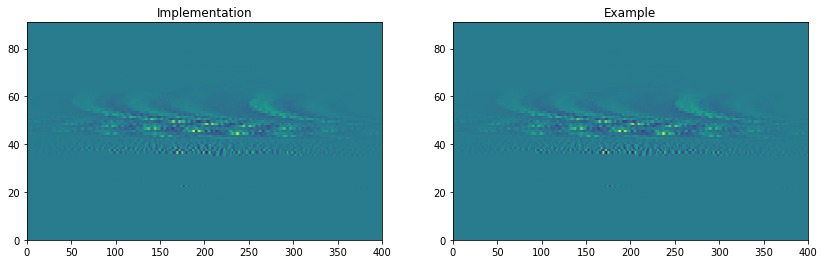

In [251]:
windowed = windowing(preemp_frames)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(windowed)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['windowed'])

### QUESTION 4.4

What is fmax in this case according to the Sampling Theorem?

Assuming that the highest frequency component for a given analog signal is fmax, according to the Nyquist-Shannon Sampling Theorem, the sampling rate should be at least 2×fmax.

Thus, since the sampling rate is equal to 20000, fmax = 10000

In [252]:
def powerSpectrum(input_frames, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    FFT = fft(input_frames, nfft)
    power_spectrum = np.square(np.absolute(FFT))
    return power_spectrum

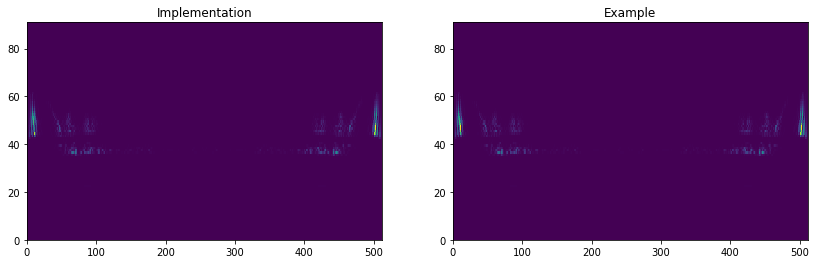

In [253]:
power_spectrum = powerSpectrum(windowed, 512)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(power_spectrum)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['spec'])

### QUESTION 5

In [254]:
# trfbank function used to create a bank of triangular filters linearly spaced in the Mel frequency scale
def trfbank(fs, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False):
    """Compute triangular filterbank for MFCC computation.

    Inputs:
    fs:         sampling frequency (rate)
    nfft:       length of the fft
    lowfreq:    frequency of the lowest filter
    linsc:      scale for the linear filters
    logsc:      scale for the logaritmic filters
    nlinfilt:   number of linear filters
    nlogfilt:   number of log filters

    Outputs:
    res:  array with shape [N, nfft], with filter amplitudes for each column.
            (N=nlinfilt+nlogfilt)
    From scikits.talkbox"""
    # Total number of filters
    nfilt = nlinfilt + nlogfilt

    #------------------------
    # Compute the filter bank
    #------------------------
    # Compute start/middle/end points of the triangular filters in spectral
    # domain
    freqs = np.zeros(nfilt+2)
    freqs[:nlinfilt] = lowfreq + np.arange(nlinfilt) * linsc
    freqs[nlinfilt:] = freqs[nlinfilt-1] * logsc ** np.arange(1, nlogfilt + 3)
    if equalareas:
        heights = np.ones(nfilt)
    else:
        heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nfilt, nfft))
    # FFT bins (in Hz)
    nfreqs = np.arange(nfft) / (1. * nfft) * fs
    for i in range(nfilt):
        low = freqs[i]
        cen = freqs[i+1]
        hi = freqs[i+2]

        lid = np.arange(np.floor(low * nfft / fs) + 1,
                        np.floor(cen * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cen - low)
        rid = np.arange(np.floor(cen * nfft / fs) + 1,
                        np.floor(hi * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (hi - cen)
        fbank[i][lid] = lslope * (nfreqs[lid] - low)
        fbank[i][rid] = rslope * (hi - nfreqs[rid])

    return fbank


def logMelSpectrum(input_frames, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    nfft = input_frames.shape[1]     
    
    banks = trfbank(samplingrate, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False)
    mspec = np.log(np.dot(input_frames, np.transpose(banks)))
    return mspec

/tmp/ipykernel_64069/962549564.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.floor(cen * nfft / fs) + 1, dtype=np.int)
/tmp/ipykernel_64069/962549564.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in N

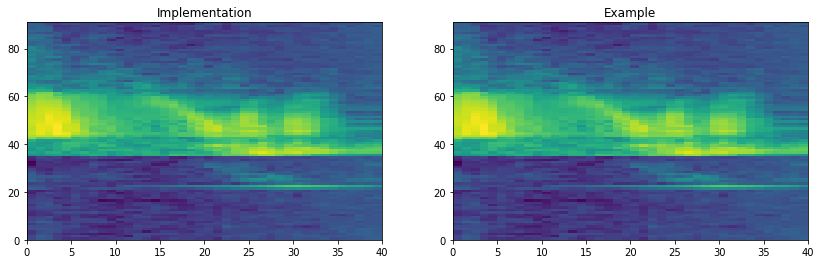

In [255]:
mspec_= logMelSpectrum(power_spectrum, 20000)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(mspec_)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['mspec'])
#fig.add_subplot(133).set_title('Filters')
#plt.pcolormesh(banks)

The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. 

Filter Banks: Amplitude of the filters decreases. The traingles tend to stay at lower frequencies at the beginning and move towards higher frequencies. As the amplitude of these triangles also decrease, the majority of the frequencies taken are the lower onces

### QUESTION 6

In [256]:
def cepstrum(input_frames, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    mfcc = realtransforms.dct(input_frames)[:,:nceps]
    return mfcc

def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.

       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient

    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    return np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))

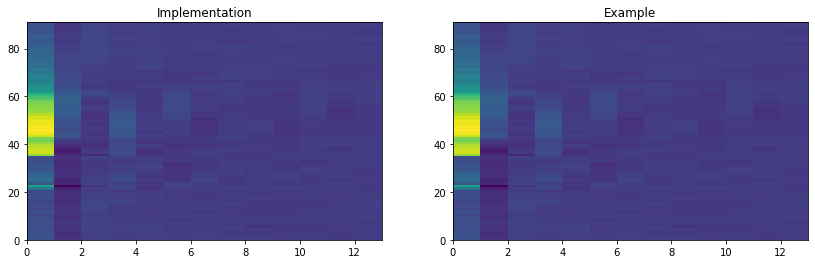

In [257]:
mfcc = cepstrum(mspec_, nceps=13)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(mfcc)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['mfcc'])

Note that using the n=13 input parameter in dct is
not the same as running without the argument and taking the first 13 elements in the results, try
to explain why.

In the dct function if the parameter n is lower than the input lenght, then the input is truncated to n --> input[:n], and the transormation is applied on this truncated array. Instead, we want to do the transormation on the intire input, and consider the first n coefficient --> resulting_coefficients[:n]

In [258]:
print(realtransforms.dct(mspec_[0], n = 13), '\n')
print('is equal to', '\n')
print(realtransforms.dct(mspec_[0][:13]), '\n')
print('but is different from', '\n')
print(realtransforms.dct(mspec_[0])[:13])

[ 1.56402199e+01  5.14166319e+00  1.28599864e+01 -1.42896245e-02
 -9.09809925e-01 -5.25718331e+00 -4.69623437e+00 -2.76765011e+00
 -2.99026728e+00 -4.17860235e-01  7.04685867e-01  3.40069259e-01
 -1.31639955e+00] 

is equal to 

[ 1.56402199e+01  5.14166319e+00  1.28599864e+01 -1.42896245e-02
 -9.09809925e-01 -5.25718331e+00 -4.69623437e+00 -2.76765011e+00
 -2.99026728e+00 -4.17860235e-01  7.04685867e-01  3.40069259e-01
 -1.31639955e+00] 

but is different from 

[ 78.81124834 -29.97987752  20.77628064   4.16987044   7.36023192
   8.17746003  15.95909756   7.30065767   7.94787463   1.72476746
   4.19099451 -11.34048447  -4.30897647]


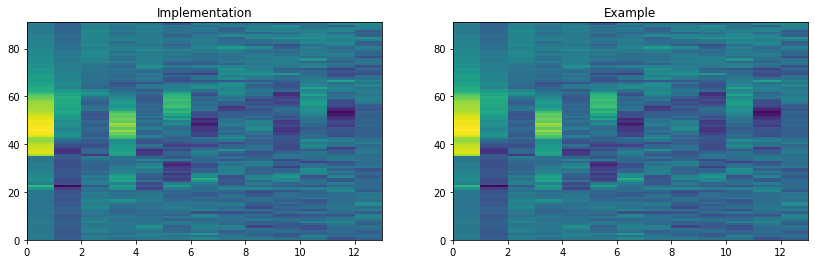

In [259]:
lfilter_ = lifter(mfcc, 22)
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121).set_title("Implementation")
plt.pcolormesh(lfilter_)
fig.add_subplot(122).set_title("Example")
plt.pcolormesh(example['lmfcc'])

In [260]:
def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """
    Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    mspecs= logMelSpectrum(spec, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, hamming
from scipy.fftpack import fft, realtransforms
from lab1_proto import mspec

In [262]:
def mspec(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

## 5. Feature corelation

/tmp/ipykernel_64069/962549564.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.floor(cen * nfft / fs) + 1, dtype=np.int)
/tmp/ipykernel_64069/962549564.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in N

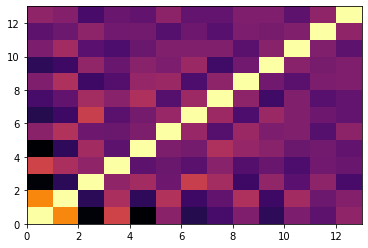

/tmp/ipykernel_64069/1176996388.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('figs/mspec_corelation.png',cmap='inferno')


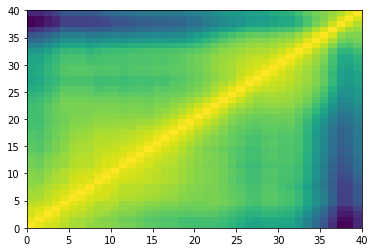

In [263]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
mfcc_utterances = list()
mspec_utterances = list()

for audio_sample in data:
    mfcc_sample = mfcc(audio_sample["samples"])
    mfcc_utterances.append(mfcc_sample)
    mspec_sample = mspec(audio_sample["samples"])
    mspec_utterances.append(mspec_sample)

mfcc_data = np.vstack(mfcc_utterances)
mspec_data = np.vstack(mspec_utterances)

mfcc_r = np.corrcoef(mfcc_data, rowvar=False)
mspec_r = np.corrcoef(mspec_data, rowvar=False)

plt.pcolormesh(mfcc_r,cmap='inferno')
plt.savefig('figs/mfcc_corelation.png',cmap='inferno')
plt.show()
plt.pcolormesh(mspec_r)
plt.savefig('figs/mspec_corelation.png',cmap='inferno')
plt.show()

## Task 6 Explore Speech Segments with Clustering

In [264]:
from sklearn.mixture import GaussianMixture

def plot_posterior_prob(posterior, component, ut):
    sum_posterior = np.sum(posterior, axis=0).reshape(1,-1)
    sum_posterior /= np.sum(posterior)
    print("Posterior Probability " + str(sum_posterior))
    plt.figure()
    plt.pcolormesh(posterior)
    plt.xlabel("Components")
    plt.ylabel("Samples")
    plt.title("Utterance nr: " + str(ut)+" Components: " + str(component))
    plt.savefig(f"figs/comp_{str(component)}_utt_{str(ut)}.png")
    plt.colorbar()
    plt.show()

In [273]:
data[16]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/7a.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': '7',
 'repetition': 'a',
 'samples': array([-1, -1, -3, ..., 13, 13, 15], dtype=int16)}

Posterior Probability [[4.69380046e-01 3.30757965e-01 1.99634511e-01 2.27477896e-04]]


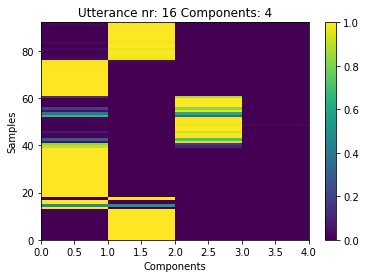

Posterior Probability [[3.68667365e-01 4.31983169e-01 1.99290020e-01 5.94446260e-05]]


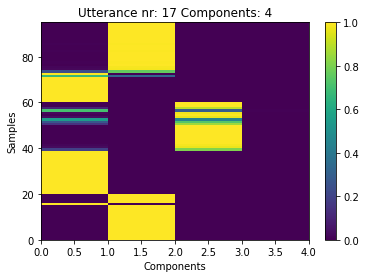

Posterior Probability [[0.50753113 0.38000579 0.00513262 0.10733045]]


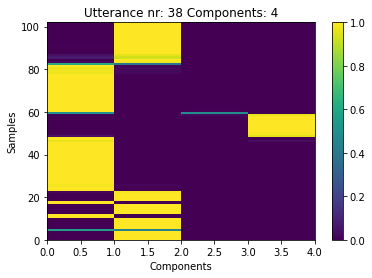

Posterior Probability [[0.46388246 0.39212277 0.01832751 0.12566726]]


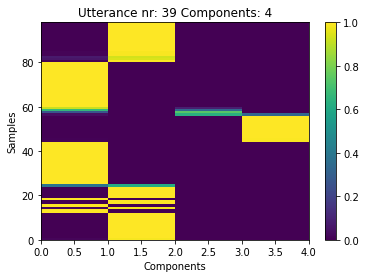

Posterior Probability [[0.08664113 0.08033359 0.18146138 0.15624929 0.10921695 0.26019873
  0.12412653 0.0017724 ]]


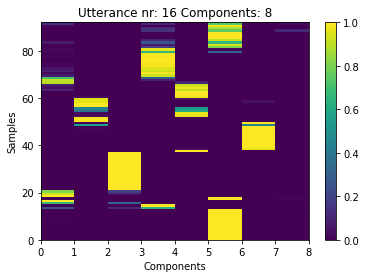

Posterior Probability [[0.05656823 0.1002801  0.15960774 0.1116436  0.12588218 0.35628005
  0.08727317 0.00246494]]


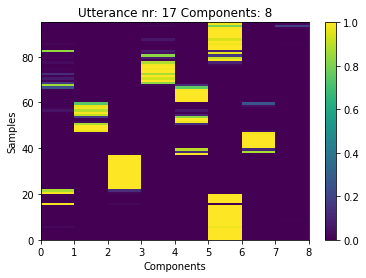

Posterior Probability [[0.23523835 0.11118015 0.25198237 0.11867181 0.00231171 0.09427257
  0.02281679 0.16352625]]


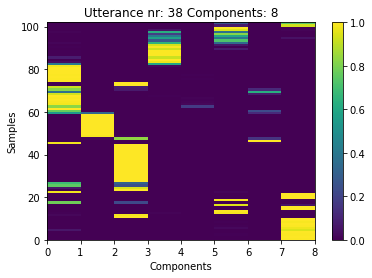

Posterior Probability [[0.19754304 0.14101605 0.18935762 0.08036797 0.00649154 0.1754566
  0.08658844 0.12317874]]


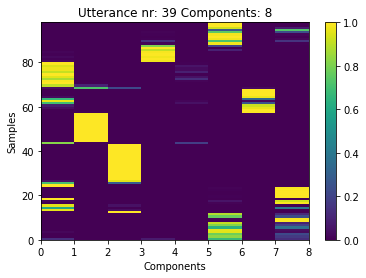

Posterior Probability [[1.19685960e-02 2.48186919e-06 2.77196823e-14 4.36759460e-02
  7.31654463e-17 1.91151411e-01 1.99441836e-01 5.14822509e-06
  5.42789311e-02 1.24943622e-01 9.59916475e-02 2.24974808e-01
  3.06409917e-03 5.04943397e-02 7.13372519e-06 3.04774611e-45]]


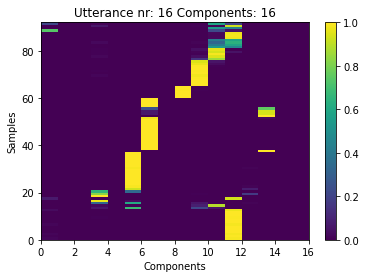

Posterior Probability [[7.38564397e-03 2.18634048e-06 1.08859565e-13 2.46011125e-02
  3.12997780e-15 1.69378000e-01 1.68478474e-01 2.86439551e-06
  6.29619847e-02 7.77640366e-02 8.36004983e-02 3.32389421e-01
  1.73161645e-04 5.30945069e-02 2.01681101e-02 1.28632173e-49]]


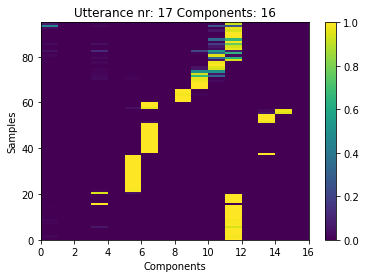

Posterior Probability [[1.67576087e-01 2.24621120e-12 7.63128270e-05 3.58462244e-02
  8.63166132e-15 1.13368424e-02 5.23905618e-02 7.80049749e-06
  3.54952371e-09 1.06303142e-01 1.53626856e-01 4.98932703e-02
  2.07694967e-01 1.07405728e-01 2.88710591e-10 1.07842203e-01]]


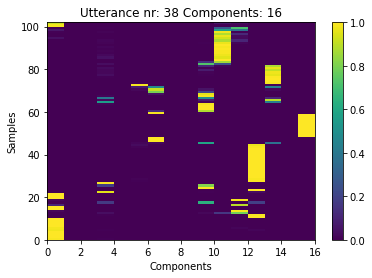

Posterior Probability [[1.62054869e-01 3.04775378e-08 2.13283881e-05 3.61861335e-02
  9.15759954e-18 3.48385947e-02 9.08093451e-02 6.14553829e-08
  1.30279374e-09 7.68802977e-02 9.97470742e-02 1.17180928e-01
  1.59369423e-01 1.20868653e-01 1.14573859e-12 1.02043260e-01]]


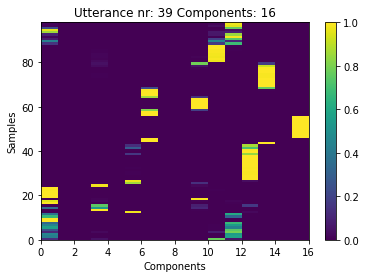

Posterior Probability [[2.31129384e-009 1.42160642e-001 1.33464726e-005 4.27833211e-002
  4.47664253e-002 8.13018061e-009 4.01336574e-005 1.08695555e-002
  5.46108312e-002 8.74542677e-012 6.70071518e-005 4.35418448e-002
  1.21574633e-016 6.84100399e-002 1.40964242e-001 3.41545571e-020
  7.09426430e-002 8.26762100e-024 1.70565245e-032 5.43018783e-002
  5.69169427e-105 3.39259036e-016 1.24197565e-002 1.95419769e-007
  6.20830488e-024 2.94593136e-011 1.38969981e-001 9.90544087e-002
  6.09325151e-002 6.65470086e-004 1.44857523e-002 6.16296797e-011]]


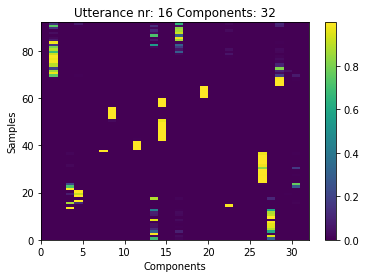

Posterior Probability [[7.21068003e-08 9.01411187e-02 1.24907042e-10 1.66653692e-02
  3.21393432e-02 1.81669856e-11 3.53561162e-04 1.05262001e-02
  7.36839811e-02 5.90843743e-08 9.30277066e-05 3.15642541e-02
  9.64909435e-14 8.30711472e-02 1.26330321e-01 1.37044068e-14
  1.41412322e-01 3.12864024e-39 1.14252126e-21 6.31551166e-02
  2.10387490e-87 8.26828822e-16 2.12150382e-03 7.42548328e-09
  9.05270465e-25 5.27050816e-14 1.16338589e-01 1.38476583e-01
  4.83086795e-02 6.56728335e-05 2.55530712e-02 3.04224227e-14]]


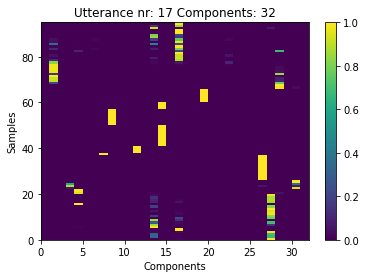

Posterior Probability [[9.12594735e-08 1.30484385e-02 5.16002258e-05 7.35571054e-02
  3.64088754e-02 6.25320760e-23 2.16455975e-06 4.35400478e-10
  8.63824739e-17 8.45420330e-02 1.51188638e-01 7.71771819e-02
  1.37254030e-01 2.24581735e-02 4.13593225e-14 1.77497271e-13
  1.02266921e-01 8.33636673e-55 7.40700395e-28 4.68734779e-10
  1.35053120e-33 3.42380230e-21 7.69019390e-02 1.49216164e-01
  1.26710639e-09 1.13661529e-14 1.41052630e-12 5.75692762e-03
  3.03775579e-02 1.11724267e-02 2.86197303e-02 1.99122802e-10]]


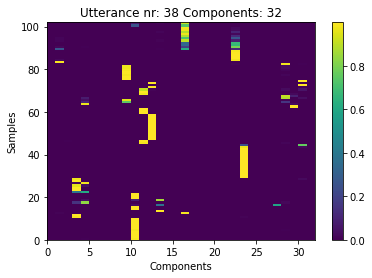

Posterior Probability [[3.72205450e-13 1.10198003e-02 2.14079463e-02 3.22072221e-02
  1.91445557e-02 4.01882113e-13 4.65660623e-04 4.59918621e-08
  1.06967399e-17 6.90119034e-02 9.69593550e-02 1.01035399e-01
  1.42879169e-01 5.83561942e-02 1.12791383e-09 4.34976155e-37
  1.49469454e-01 1.30936596e-42 1.91090552e-50 1.28688742e-11
  3.56531908e-34 1.55037233e-16 6.59980807e-02 1.40754775e-01
  1.57396796e-19 5.09478838e-19 1.86868821e-10 1.61197452e-04
  4.36198393e-02 1.62333742e-02 3.12760264e-02 2.33348934e-13]]


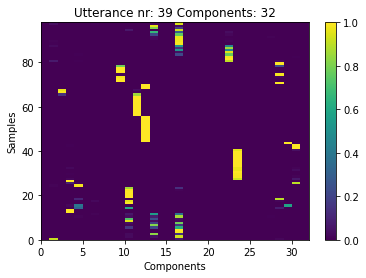

In [265]:
components = [4, 8, 16, 32]

for component in components:
    g = GaussianMixture(n_components=component)
    g.fit(mfcc_data)
    for utt in [16,17,38,39]:
        posterior = g.predict_proba(mfcc_utterances[utt])
        plot_posterior_prob(posterior, component, utt)

In [ ]:
posterior

### 7 Comparing Utterances

In [266]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import cdist
from lab1_tools import lifter, trfbank, tidigit2labels
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy

def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    lc_dist = dist(x, y)
    acc_dist = float('inf') * np.ones(lc_dist.shape)
    acc_dist[0, 0] = lc_dist[0, 0]
    for i in range(1, acc_dist.shape[1]):
        acc_dist[0, i] = acc_dist[0, i - 1] + lc_dist[0, i]
    for i in range(1, acc_dist.shape[0]):
        acc_dist[i, 0] = acc_dist[i - 1, 0] + lc_dist[i, 0]

    for i in range(1, acc_dist.shape[0]):
        for j in range(1, acc_dist.shape[1]):
            acc_dist[i, j] = lc_dist[i, j] + min(acc_dist[i - 1, j], acc_dist[i, j - 1], acc_dist[i - 1, j - 1])

    gl_distance = acc_dist[-1, -1] / (x.shape[0] + y.shape[0])

    return gl_distance, lc_dist, acc_dist

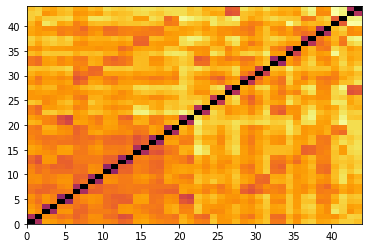

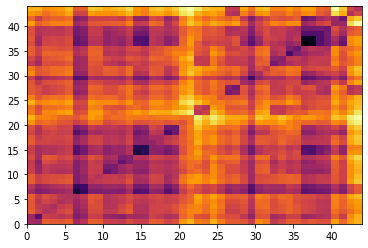

/tmp/ipykernel_64069/1916847838.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_distances = linkage(global_distances, method='complete')


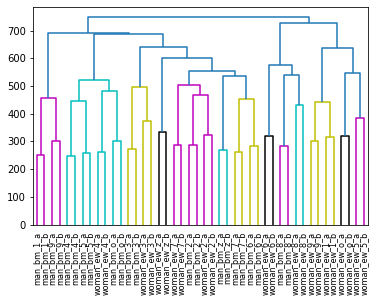

In [276]:
global_distances = np.zeros((len(mfcc_utterances), len(mfcc_utterances)))
euclidian_distances = np.zeros((len(mfcc_utterances), len(mfcc_utterances)))
for i in range(global_distances.shape[0]):
    for j in range(global_distances.shape[1]):
        global_distances[i, j] = dtw(mfcc_utterances[i], mfcc_utterances[j],cdist)[0]
        euclidian_distances[i, j] = np.mean(dtw(mfcc_utterances[i], mfcc_utterances[j],cdist)[1])

plt.pcolormesh(global_distances,cmap='inferno')
plt.savefig("figs/dtw_utterance_comparison.png")
plt.show()

plt.pcolormesh(euclidian_distances,cmap='inferno')
plt.savefig("figs/mean_euclidian_utterance_comparison.png")
plt.show()

linkage_distances = linkage(global_distances, method='complete')
labels = tidigit2labels(data)
dn = dendrogram(linkage_distances, labels=labels)

plt.savefig("figs/hierarchy_clustering.png")
plt.show()

In [275]:
dtw(mfcc_utterances[i], mfcc_utterances[j],cdist)[1]

array([[  0.        , 230.27843248, 486.05637365, ..., 361.21297584,
        472.99022063, 453.83356824],
       [230.27843248,   0.        , 466.88647971, ..., 339.6170788 ,
        446.65995703, 376.41415129],
       [486.05637365, 466.88647971,   0.        , ..., 645.04307889,
        563.90945366, 535.39821999],
       ...,
       [361.21297584, 339.6170788 , 645.04307889, ...,   0.        ,
        408.32604233, 355.01260592],
       [472.99022063, 446.65995703, 563.90945366, ..., 408.32604233,
          0.        , 289.53290478],
       [453.83356824, 376.41415129, 535.39821999, ..., 355.01260592,
        289.53290478,   0.        ]])